In [430]:
import json
import numpy as np
from symmer.chem import MoleculeBuilder
from symmer.projection import QubitTapering, CS_VQE, StabilizerIdentification
from symmer.symplectic import ObservableGraph, PauliwordOp

with open('../data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)    

speciesname = 'LiH_STO-3G_SINGLET'
print(speciesname)
# build the molecule
mol_data = molecule_geometries[speciesname]
atoms  = mol_data['atoms']
coords = mol_data['coords']
charge = mol_data['charge']
basis = mol_data['basis']
geometry = list(zip(atoms, coords))
molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, spin=0, run_fci=True, print_info=True)

LiH_STO-3G_SINGLET
Molecule geometry:
Li	0.0	0.0	0.3868
H	0.0	0.0	-1.1605

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -7.863115321486977
MP2 energy:  -7.875625276066905
CCSD energy: -7.882752312997108
FCI energy:  -7.882762230971985


Number of qubits: 12


In [431]:
# taper the Hamiltonian
qubit_tapering = QubitTapering(molecule.H_q)
hf_array = molecule.H_fermion.hf_comp_basis_state
qubit_tapering.stabilizers.update_sector(hf_array)
ham_tap = qubit_tapering.taper_it(ref_state=hf_array)
ucc_tap = qubit_tapering.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
hf_tapered = qubit_tapering.tapered_ref_state

print(f'Qubit tapering permitted a reduction of {molecule.H_q.n_qubits} -> {ham_tap.n_qubits} qubits\n')
print('The following stabilizers were identified:\n')
print(qubit_tapering.stabilizers)

Qubit tapering permitted a reduction of 12 -> 8 qubits

The following stabilizers were identified:

 1 ZIZIZIIZIZZI 
 1 IZIZIZIZIZIZ 
 1 IIIIIIZZIIII 
 1 IIIIIIIIZZII


In [432]:
from qiskit.circuit.library import ExcitationPreserving
from qiskit import QuantumCircuit

excitation_circuit = ExcitationPreserving(molecule.n_qubits).decompose().decompose()

qc = QuantumCircuit(molecule.n_qubits)
for i in np.where(hf_array)[0]:
    qc.x(molecule.n_qubits-1-i)
qc.barrier()
qc = qc.compose(excitation_circuit)

print(f'Number of parameters: {qc.num_parameters}')
qc.draw()

Number of parameters: 246


global phase: -0.5*θ[0] - 0.5*θ[10] - 0.5*θ[11] - 0.5*θ[156] - 0.5*θ[157] - 0.5*θ[158] - 0.5*θ[159] - 0.5*θ[160] - 0.5*θ[161] - 0.5*θ[162] - 0.5*θ[163] - 0.5*θ[164] - 0.5*θ[165] - 0.5*θ[166] - 0.5*θ[167] - 0.5*θ[1] - 0.5*θ[234] - 0.5*θ[235] - 0.5*θ[236] - 0.5*θ[237] - 0.5*θ[238] - 0.5*θ[239] - 0.5*θ[240] - 0.5*θ[241] - 0.5*θ[242] - 0.5*θ[243] - 0.5*θ[244] - 0.5*θ[245] - 0.5*θ[2] - 0.5*θ[3] - 0.5*θ[4] - 0.5*θ[5] - 0.5*θ[6] - 0.5*θ[78] - 0.5*θ[79] - 0.5*θ[7] - 0.5*θ[80] - 0.5*θ[81] - 0.5*θ[82] - 0.5*θ[83] - 0.5*θ[84] - 0.5*θ[85] - 0.5*θ[86] - 0.5*θ[87] - 0.5*θ[88] - 0.5*θ[89] - 0.5*θ[8] - 0.5*θ[9]
            ░  ┌──────────┐┌───┐                       ┌───┐┌─────────┐     »
 q_0: ──────░──┤ U1(θ[0]) ├┤ H ├──■─────────────────■──┤ H ├┤ Rx(π/2) ├──■──»
            ░  ├──────────┤├───┤┌─┴─┐┌───────────┐┌─┴─┐├───┤├─────────┤┌─┴─┐»
 q_1: ──────░──┤ U1(θ[1]) ├┤ H ├┤ X ├┤ Rz(θ[12]) ├┤ X ├┤ H ├┤ Rx(π/2) ├┤ X ├»
            ░  ├──────────┤├───┤└───┘└───────────┘└───┘└───┘└─────────┘└───┘»
 q_2: ──────░──┤ U1(θ[2]) ├┤ H ├────────────────────────────────────────────»
            ░  ├──────────┤├───┤                                            »
 q_3: ──────░──┤ U1(θ[3]) ├┤ H ├────────────────────────────────────────────»
            ░  ├──────────┤├───┤                                            »
 q_4: ──────░──┤ U1(θ[4]) ├┤ H ├────────────────────────────────────────────»
            ░  ├──────────┤├───┤                                            »
 q_5: ──────░──┤ U1(θ[5]) ├┤ H ├────────────────────────────────────────────»
            ░  ├──────────┤├───┤                                            »
 q_6: ──────░──┤ U1(θ[6]) ├┤ H ├────────────────────────────────────────────»
            ░  ├──────────┤├───┤                                            »
 q_7: ──────░──┤ U1(θ[7]) ├┤ H ├────────────────────────────────────────────»
      ┌───┐ ░  ├──────────┤├───┤                                            »
 q_8: ┤ X ├─░──┤ U1(θ[8]) ├┤ H ├────────────────────────────────────────────»
      ├───┤ ░  ├──────────┤├───┤                                            »
 q_9: ┤ X ├─░──┤ U1(θ[9]) ├┤ H ├────────────────────────────────────────────»
      ├───┤ ░ ┌┴──────────┤├───┤                                            »
q_10: ┤ X ├─░─┤ U1(θ[10]) ├┤ H ├────────────────────────────────────────────»
      ├───┤ ░ ├───────────┤├───┤                                            »
q_11: ┤ X ├─░─┤ U1(θ[11]) ├┤ H ├────────────────────────────────────────────»
      └───┘ ░ └───────────┘└───┘                                            »
«                        ┌──────────┐┌───┐                       ┌───┐»
« q_0: ───────────────■──┤ Rx(-π/2) ├┤ H ├──■─────────────────■──┤ H ├»
«      ┌───────────┐┌─┴─┐├──────────┤├───┤  │                 │  └───┘»
« q_1: ┤ Rz(θ[12]) ├┤ X ├┤ Rx(-π/2) ├┤ H ├──┼─────────────────┼───────»
«      └───────────┘└───┘└──────────┘└───┘┌─┴─┐┌───────────┐┌─┴─┐┌───┐»
« q_2: ───────────────────────────────────┤ X ├┤ Rz(θ[13]) ├┤ X ├┤ H ├»
«                                         └───┘└───────────┘└───┘└───┘»
« q_3: ───────────────────────────────────────────────────────────────»
«                                                                     »
« q_4: ───────────────────────────────────────────────────────────────»
«                                                                     »
« q_5: ───────────────────────────────────────────────────────────────»
«                                                                     »
« q_6: ───────────────────────────────────────────────────────────────»
«                                                                     »
« q_7: ───────────────────────────────────────────────────────────────»
«                                                                     »
« q_8: ───────────────────────────────────────────────────────────────»
«                                                                     »
« q_9: ───────────────────────────────────────────────────────────────»
«      

In [433]:
def drop_qubits_from_circuit(qc, drop_indices, fixed_values):
    assert(len(drop_indices)==len(fixed_values)), 'Number of indices to drop and corresponding eigenvalues do not match'
    n_qubits_in = qc.num_qubits
    n_qubits_out= n_qubits_in-len(drop_indices)
    qc_red = QuantumCircuit(n_qubits_out)
    q_map = {
        q_in:q_out for q_in, q_out in zip(
            np.setdiff1d(np.arange(n_qubits_in), drop_indices), 
            np.arange(n_qubits_out)
        )
    }
    for q in drop_indices:
        q_map[q] = None
    eigmap = {drop:eig for drop,eig in zip(drop_indices, fixed_values)}
        
    for instruction, qubits, blank in qc.data:
        gate  = instruction.name
        param = instruction.params
        if param != []:
            param = param[0]   
        q_index_in, q_index_out = zip(*[(q.index,q_map[q.index]) for q in qubits])
    
        if gate == 'cx':
            #c_index control qubit, q_index the target
            c_in,  t_in  = q_index_in
            c_out, t_out = q_index_out
        else:
            c_in, c_out = None, None
            t_in, t_out = q_index_in[0], q_index_out[0]

        if t_out is not None:
            if gate=='cx':
                if c_out is None:
                    if eigmap[c_in]==1:
                        qc_red.x(t_out)
                else:
                    qc_red.cx(c_out, t_out)

            elif gate=='rx':
                qc_red.rx(param, t_out)
            elif gate=='rz':
                qc_red.rz(param, t_out)
            elif gate in ['u1', 'p']:
                qc_red.p(param, t_out)
            elif gate=='h':
                qc_red.h(t_out)
            elif gate=='x':
                qc_red.x(t_out)
            else:
                raise(ValueError('Gate not recognised'))
        
    return qc_red

In [434]:
taper_drop_indices = qubit_tapering.stab_qubit_indices[::-1]
taper_fixed_values = qubit_tapering.stabilizers.coeff_vec

qc_taper = drop_qubits_from_circuit(qc, taper_drop_indices, taper_fixed_values)

print(f'Number of parameters: {qc_taper.num_parameters}')
qc_taper.draw()

/tmp/ipykernel_39231/2267129237.py:21: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q_index_in, q_index_out = zip(*[(q.index,q_map[q.index]) for q in qubits])


Number of parameters: 185


┌─────────┐   ┌───┐    ┌───┐┌───────────┐    ┌───┐    ┌───┐┌─────────┐»
q_0: ┤ P(θ[2]) ├───┤ H ├────┤ X ├┤ Rz(θ[13]) ├────┤ X ├────┤ H ├┤ Rx(π/2) ├»
     ├─────────┤   ├───┤    ├───┤├───────────┤    ├───┤    ├───┤├─────────┤»
q_1: ┤ P(θ[3]) ├───┤ H ├────┤ X ├┤ Rz(θ[14]) ├────┤ X ├────┤ H ├┤ Rx(π/2) ├»
     ├─────────┤   ├───┤    ├───┤├───────────┤    ├───┤    ├───┤├─────────┤»
q_2: ┤ P(θ[4]) ├───┤ H ├────┤ X ├┤ Rz(θ[15]) ├────┤ X ├────┤ H ├┤ Rx(π/2) ├»
     ├─────────┤   ├───┤    ├───┤├───────────┤    ├───┤    ├───┤├─────────┤»
q_3: ┤ P(θ[5]) ├───┤ H ├────┤ X ├┤ Rz(θ[16]) ├────┤ X ├────┤ H ├┤ Rx(π/2) ├»
     ├─────────┤   ├───┤    ├───┤├───────────┤    ├───┤    ├───┤├─────────┤»
q_4: ┤ P(θ[7]) ├───┤ H ├────┤ X ├┤ Rz(θ[18]) ├────┤ X ├────┤ H ├┤ Rx(π/2) ├»
     └──┬───┬──┘┌──┴───┴──┐ ├───┤└───┬───┬───┘┌───┴───┴───┐├───┤└──┬───┬──┘»
q_5: ───┤ X ├───┤ P(θ[9]) ├─┤ H ├────┤ X ├────┤ Rz(θ[20]) ├┤ X ├───┤ H ├───»
        ├───┤   ├─────────┴┐├───┤    ├───┤    ├───────────┤├───┤   ├───┤   »
q_6: ───┤ X ├───┤ P(θ[10]) ├┤ H ├────┤ X ├────┤ Rz(θ[21]) ├┤ X ├───┤ H ├───»
        ├───┤   ├──────────┤├───┤    ├───┤    ├───────────┤├───┤   ├───┤   »
q_7: ───┤ X ├───┤ P(θ[11]) ├┤ H ├────┤ X ├────┤ Rz(θ[22]) ├┤ X ├───┤ H ├───»
        └───┘   └──────────┘└───┘    └───┘    └───────────┘└───┘   └───┘   »
«        ┌───┐   ┌───────────┐    ┌───┐    ┌──────────┐   ┌───┐    ┌───┐»
«q_0: ───┤ X ├───┤ Rz(θ[13]) ├────┤ X ├────┤ Rx(-π/2) ├───┤ H ├────┤ X ├»
«        ├───┤   ├───────────┤    ├───┤    ├──────────┤   ├───┤    ├───┤»
«q_1: ───┤ X ├───┤ Rz(θ[14]) ├────┤ X ├────┤ Rx(-π/2) ├───┤ H ├────┤ X ├»
«        ├───┤   ├───────────┤    ├───┤    ├──────────┤   ├───┤    ├───┤»
«q_2: ───┤ X ├───┤ Rz(θ[15]) ├────┤ X ├────┤ Rx(-π/2) ├───┤ H ├────┤ X ├»
«        ├───┤   ├───────────┤    ├───┤    ├──────────┤   ├───┤    ├───┤»
«q_3: ───┤ X ├───┤ Rz(θ[16]) ├────┤ X ├────┤ Rx(-π/2) ├───┤ H ├────┤ X ├»
«        ├───┤   ├───────────┤    ├───┤    ├──────────┤   ├───┤    ├───┤»
«q_4: ───┤ X ├───┤ Rz(θ[18]) ├────┤ X ├────┤ Rx(-π/2) ├───┤ H ├────┤ X ├»
«     ┌──┴───┴──┐└───┬───┬───┘┌───┴───┴───┐└──┬───┬───┘┌──┴───┴───┐├───┤»
«q_5: ┤ Rx(π/2) ├────┤ X ├────┤ Rz(θ[20]) ├───┤ X ├────┤ Rx(-π/2) ├┤ H ├»
«     ├─────────┤    ├───┤    ├───────────┤   ├───┤    ├──────────┤├───┤»
«q_6: ┤ Rx(π/2) ├────┤ X ├────┤ Rz(θ[21]) ├───┤ X ├────┤ Rx(-π/2) ├┤ H ├»
«     ├─────────┤    ├───┤    ├───────────┤   ├───┤    ├──────────┤├───┤»
«q_7: ┤ Rx(π/2) ├────┤ X ├────┤ Rz(θ[22]) ├───┤ X ├────┤ Rx(-π/2) ├┤ H ├»
«     └─────────┘    └───┘    └───────────┘   └───┘    └──────────┘└───┘»
«     ┌───────────┐    ┌───┐    ┌───┐┌─────────┐   ┌───┐   ┌───────────┐»
«q_0: ┤ Rz(θ[23]) ├────┤ X ├────┤ H ├┤ Rx(π/2) ├───┤ X ├───┤ Rz(θ[23]) ├»
«     ├───────────┤    ├───┤    ├───┤├─────────┤   ├───┤   ├───────────┤»
«q_1: ┤ Rz(θ[24]) ├────┤ X ├────┤ H ├┤ Rx(π/2) ├───┤ X ├───┤ Rz(θ[24]) ├»
«     ├───────────┤    ├───┤    ├───┤├─────────┤   ├───┤   ├───────────┤»
«q_2: ┤ Rz(θ[25]) ├────┤ X ├────┤ H ├┤ Rx(π/2) ├───┤ X ├───┤ Rz(θ[25]) ├»
«     ├───────────┤    ├───┤    ├───┤├─────────┤   ├───┤   ├───────────┤»
«q_3: ┤ Rz(θ[26]) ├────┤ X ├────┤ H ├┤ Rx(π/2) ├───┤ X ├───┤ Rz(θ[26]) ├»
«     ├───────────┤    ├───┤    ├───┤├─────────┤   ├───┤   ├───────────┤»
«q_4: ┤ Rz(θ[28]) ├────┤ X ├────┤ H ├┤ Rx(π/2) ├───┤ X ├───┤ Rz(θ[28]) ├»
«     └───┬───┬───┘┌───┴───┴───┐├───┤└──┬───┬──┘┌──┴───┴──┐└───┬───┬───┘»
«q_5: ────┤ X ├────┤ Rz(θ[30]) ├┤ X ├───┤ H ├───┤ Rx(π/2) ├────┤ X ├────»
«         ├───┤    ├───────────┤├───┤   ├───┤   ├─────────┤    ├───┤    »
«q_6: ────┤ X ├────┤ Rz(θ[31]) ├┤ X ├───┤ H ├───┤ Rx(π/2) ├────┤ X ├────»
«         ├───┤    ├───────────┤├───┤   ├───┤   ├─────────┤    ├───┤    »
«q_7: ────┤ X ├────┤ Rz(θ[32]) ├┤ X ├───┤ H ├───┤ Rx(π/2) ├────┤ X ├────»
«         └───┘    └───────────┘└───┘   └───┘   └─────────┘    └───┘    »
«         ┌───┐    ┌──────────┐   ┌───┐                           ┌───┐»
«q_0: ────┤ X ├────┤ Rx(-π/2) ├───┤ H ├──────■─────────────────■──┤ H ├»
«         ├───┤    ├──────────┤   

In [435]:
n_qubits = 4
# CS-VQE and stabilizer identification
cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
CC_stabilizers = StabilizerIdentification(ucc_tap)
S = CC_stabilizers.symmetry_basis_by_subspace_dimension(n_qubits)
ham_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False)
ham_cs.to_PauliSumOp

PauliSumOp(SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'IZZI', 'IZZZ', 'ZIII', 'ZIIZ', 'ZIZI', 'ZIZZ', 'ZZII', 'ZZIZ', 'ZZZI', 'ZZZZ', 'IIIX', 'IIZX', 'IZIX', 'IZZX', 'ZIIX', 'ZIZX', 'ZZIX', 'ZZZX', 'IIXI', 'IIXZ', 'IZXI', 'IZXZ', 'ZIXI', 'ZIXZ', 'ZZXI', 'ZZXZ', 'IIYY', 'IZYY', 'ZIYY', 'ZZYY', 'IXII', 'IXIZ', 'IXZI', 'IXZZ', 'ZXII', 'ZXIZ', 'ZXZI', 'ZXZZ', 'IXIX', 'IXZX', 'IYIY', 'IYZY', 'ZXIX', 'ZXZX', 'ZYIY', 'ZYZY', 'IXXI', 'IXXZ', 'ZXXI', 'ZXXZ', 'IXYY', 'IYYX', 'ZXYY', 'ZYYX', 'XIII', 'XIIZ', 'XIZI', 'XIZZ', 'XZII', 'XZIZ', 'XZZI', 'XZZZ', 'YIIY', 'YIZY', 'YZIY', 'YZZY', 'XIXI', 'XIXZ', 'XZXI', 'XZXZ', 'YIYI', 'YIYZ', 'YZYI', 'YZYZ', 'XIXX', 'XZXX', 'YIYX', 'YZYX', 'YYII', 'YYIZ', 'YYZI', 'YYZZ', 'XXIX', 'XXZX', 'XYIY', 'XYZY', 'XYYI', 'XYYZ', 'YYXI', 'YYXZ', 'XXYY', 'XYYX', 'YXXY', 'YYXX'],
              coeffs=[-6.99589146+0.j, -0.36527168+0.j, -0.36527168+0.j,  0.11384458+0.j,
 -0.2118906 +0.j,  0.0927578 +0.j,  0.06043936+0.j, -0.11395419+0.j,
 -0.2118906 +0

In [436]:
from symmer.symplectic import QuantumState, array_to_QuantumState
from symmer.utils import exact_gs_energy

gs_energy, gs_vec = exact_gs_energy(ham_cs.to_sparse_matrix)
gs_psi = array_to_QuantumState(gs_vec)

print(gs_psi)

-0.9886631032+0.0000000000j |0000> +
-0.0049638100+0.0000000000j |0001> +
 0.0049638100+0.0000000000j |0010> +
 0.1116452324+0.0000000000j |0011> +
-0.0326658185+0.0000000000j |0100> +
 0.0576224273+0.0000000000j |0110> +
 0.0326658185+0.0000000000j |1000> +
-0.0576224273+0.0000000000j |1001> +
 0.0354475958+0.0000000000j |1100>


In [437]:
cs_drop_indices = cs_vqe.stab_qubit_indices[::-1]
cs_fixed_values = cs_vqe.stabilizers.coeff_vec

qc_cs_vqe = drop_qubits_from_circuit(qc_taper, cs_drop_indices, cs_fixed_values)
print(f'Number of parameters: {qc_cs_vqe.num_parameters}')
qc_cs_vqe.draw()

Number of parameters: 106


/tmp/ipykernel_39231/2267129237.py:21: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q_index_in, q_index_out = zip(*[(q.index,q_map[q.index]) for q in qubits])


┌─────────┐   ┌───┐    ┌───┐┌───────────┐    ┌───┐    ┌───┐┌─────────┐»
q_0: ┤ P(θ[4]) ├───┤ H ├────┤ X ├┤ Rz(θ[15]) ├────┤ X ├────┤ H ├┤ Rx(π/2) ├»
     ├─────────┤   ├───┤    ├───┤├───────────┤    ├───┤    ├───┤├─────────┤»
q_1: ┤ P(θ[5]) ├───┤ H ├────┤ X ├┤ Rz(θ[16]) ├────┤ X ├────┤ H ├┤ Rx(π/2) ├»
     └──┬───┬──┘┌──┴───┴───┐├───┤└───┬───┬───┘┌───┴───┴───┐├───┤└──┬───┬──┘»
q_2: ───┤ X ├───┤ P(θ[10]) ├┤ H ├────┤ X ├────┤ Rz(θ[21]) ├┤ X ├───┤ H ├───»
        ├───┤   ├──────────┤├───┤    ├───┤    ├───────────┤├───┤   ├───┤   »
q_3: ───┤ X ├───┤ P(θ[11]) ├┤ H ├────┤ X ├────┤ Rz(θ[22]) ├┤ X ├───┤ H ├───»
        └───┘   └──────────┘└───┘    └───┘    └───────────┘└───┘   └───┘   »
«        ┌───┐   ┌───────────┐    ┌───┐    ┌──────────┐   ┌───┐    ┌───┐»
«q_0: ───┤ X ├───┤ Rz(θ[15]) ├────┤ X ├────┤ Rx(-π/2) ├───┤ H ├────┤ X ├»
«        ├───┤   ├───────────┤    ├───┤    ├──────────┤   ├───┤    ├───┤»
«q_1: ───┤ X ├───┤ Rz(θ[16]) ├────┤ X ├────┤ Rx(-π/2) ├───┤ H ├────┤ X ├»
«     ┌──┴───┴──┐└───┬───┬───┘┌───┴───┴───┐└──┬───┬───┘┌──┴───┴───┐├───┤»
«q_2: ┤ Rx(π/2) ├────┤ X ├────┤ Rz(θ[21]) ├───┤ X ├────┤ Rx(-π/2) ├┤ H ├»
«     ├─────────┤    ├───┤    ├───────────┤   ├───┤    ├──────────┤├───┤»
«q_3: ┤ Rx(π/2) ├────┤ X ├────┤ Rz(θ[22]) ├───┤ X ├────┤ Rx(-π/2) ├┤ H ├»
«     └─────────┘    └───┘    └───────────┘   └───┘    └──────────┘└───┘»
«     ┌───────────┐    ┌───┐    ┌───┐┌─────────┐   ┌───┐   ┌───────────┐»
«q_0: ┤ Rz(θ[25]) ├────┤ X ├────┤ H ├┤ Rx(π/2) ├───┤ X ├───┤ Rz(θ[25]) ├»
«     ├───────────┤    ├───┤    ├───┤├─────────┤   ├───┤   ├───────────┤»
«q_1: ┤ Rz(θ[26]) ├────┤ X ├────┤ H ├┤ Rx(π/2) ├───┤ X ├───┤ Rz(θ[26]) ├»
«     └───┬───┬───┘┌───┴───┴───┐├───┤└──┬───┬──┘┌──┴───┴──┐└───┬───┬───┘»
«q_2: ────┤ X ├────┤ Rz(θ[31]) ├┤ X ├───┤ H ├───┤ Rx(π/2) ├────┤ X ├────»
«         ├───┤    ├───────────┤├───┤   ├───┤   ├─────────┤    ├───┤    »
«q_3: ────┤ X ├────┤ Rz(θ[32]) ├┤ X ├───┤ H ├───┤ Rx(π/2) ├────┤ X ├────»
«         └───┘    └───────────┘└───┘   └───┘   └─────────┘    └───┘    »
«         ┌───┐    ┌──────────┐   ┌───┐    ┌───────────┐    ┌───┐    »
«q_0: ────┤ X ├────┤ Rx(-π/2) ├───┤ H ├────┤ Rz(θ[34]) ├────┤ H ├────»
«         ├───┤    ├──────────┤   ├───┤    ├───────────┤    ├───┤    »
«q_1: ────┤ X ├────┤ Rx(-π/2) ├───┤ H ├────┤ Rz(θ[35]) ├────┤ H ├────»
«     ┌───┴───┴───┐└──┬───┬───┘┌──┴───┴───┐└───┬───┬───┘┌───┴───┴───┐»
«q_2: ┤ Rz(θ[31]) ├───┤ X ├────┤ Rx(-π/2) ├────┤ H ├────┤ Rz(θ[40]) ├»
«     ├───────────┤   ├───┤    ├──────────┤    ├───┤    ├───────────┤»
«q_3: ┤ Rz(θ[32]) ├───┤ X ├────┤ Rx(-π/2) ├────┤ H ├────┤ Rz(θ[41]) ├»
«     └───────────┘   └───┘    └──────────┘    └───┘    └───────────┘»
«     ┌─────────┐┌───────────┐ ┌──────────┐   ┌───┐    ┌───────────┐»
«q_0: ┤ Rx(π/2) ├┤ Rz(θ[34]) ├─┤ Rx(-π/2) ├───┤ H ├────┤ Rz(θ[42]) ├»
«     ├─────────┤├───────────┤ ├──────────┤   ├───┤    ├───────────┤»
«q_1: ┤ Rx(π/2) ├┤ Rz(θ[35]) ├─┤ Rx(-π/2) ├───┤ H ├────┤ Rz(θ[43]) ├»
«     └──┬───┬──┘└┬─────────┬┘┌┴──────────┤┌──┴───┴───┐└───┬───┬───┘»
«q_2: ───┤ H ├────┤ Rx(π/2) ├─┤ Rz(θ[40]) ├┤ Rx(-π/2) ├────┤ H ├────»
«        ├───┤    ├─────────┤ ├───────────┤├──────────┤    ├───┤    »
«q_3: ───┤ H ├────┤ Rx(π/2) ├─┤ Rz(θ[41]) ├┤ Rx(-π/2) ├────┤ H ├────»
«        └───┘    └─────────┘ └───────────┘└──────────┘    └───┘    »
«         ┌───┐    ┌─────────┐┌───────────┐ ┌──────────┐   ┌───┐         »
«q_0: ────┤ H ├────┤ Rx(π/2) ├┤ Rz(θ[42]) ├─┤ Rx(-π/2) ├───┤ H ├──────■──»
«         ├───┤    ├─────────┤├───────────┤ ├──────────┤   ├───┤    ┌─┴─┐»
«q_1: ────┤ H ├────┤ Rx(π/2) ├┤ Rz(θ[43]) ├─┤ Rx(-π/2) ├───┤ H ├────┤ X ├»
«     ┌───┴───┴───┐└──┬───┬──┘└┬─────────┬┘┌┴──────────┤┌──┴───┴───┐├───┤»
«q_2: ┤ Rz(θ[48]) ├───┤ H ├────┤ Rx(π/2) ├─┤ Rz(θ[48]) ├┤ Rx(-π/2) ├┤ H ├»
«     ├───────────┤   ├───┤    ├─────────┤ ├───────────┤├──────────┤├───┤»
«q_3: ┤ Rz(θ[49]) ├───┤ H ├────┤ Rx(π/2) ├─┤ Rz(θ[49]) ├┤ Rx(-π/2) ├┤ H ├»
«     └───────────┘   └───┘    └─────────┘ └───────────┘└──────────┘└───┘»
«                       ┌───┐┌──────

In [438]:
from qiskit import transpile

ansatz = transpile(qc_cs_vqe, optimization_level=3)

#to_pop = []
#for index, (instruction, qubit, blank) in enumerate(ansatz.data):
#    current_q_ind = qubit[-1].index
#    if index!=len(ansatz.data)-1:
#        next_instruction, next_qubit, next_blank = ansatz.data[index+1]
#        next_q_ind = next_qubit[-1].index
#    if current_q_ind == next_q_ind:
#        if instruction.name.find('r')!=-1 and next_instruction.name.find('r')!=-1:
#            to_pop.append(index+1)

#ansatz.data = [step for index,step in enumerate(ansatz.data) if index not in to_pop]
print(f'Number of parameters: {ansatz.num_parameters}')
ansatz.draw()

Number of parameters: 106


┌─────────┐   ┌───┐    ┌───┐┌───────────┐    ┌───┐    ┌───┐┌──────────┐»
q_0: ┤ P(θ[4]) ├───┤ H ├────┤ X ├┤ Rz(θ[15]) ├────┤ X ├────┤ H ├┤ Rx(3π/2) ├»
     ├─────────┤   ├───┤    ├───┤├───────────┤    ├───┤    ├───┤├──────────┤»
q_1: ┤ P(θ[5]) ├───┤ H ├────┤ X ├┤ Rz(θ[16]) ├────┤ X ├────┤ H ├┤ Rx(3π/2) ├»
     └──┬───┬──┘┌──┴───┴───┐├───┤└───┬───┬───┘┌───┴───┴───┐├───┤└──┬───┬───┘»
q_2: ───┤ X ├───┤ P(θ[10]) ├┤ H ├────┤ X ├────┤ Rz(θ[21]) ├┤ X ├───┤ H ├────»
        ├───┤   ├──────────┤├───┤    ├───┤    ├───────────┤├───┤   ├───┤    »
q_3: ───┤ X ├───┤ P(θ[11]) ├┤ H ├────┤ X ├────┤ Rz(θ[22]) ├┤ X ├───┤ H ├────»
        └───┘   └──────────┘└───┘    └───┘    └───────────┘└───┘   └───┘    »
«     ┌───────────┐ ┌─────────┐    ┌───┐   ┌───┐┌───────────┐    ┌───┐    ┌───┐»
«q_0: ┤ Rz(θ[15]) ├─┤ Rx(π/2) ├────┤ H ├───┤ X ├┤ Rz(θ[25]) ├────┤ X ├────┤ H ├»
«     ├───────────┤ ├─────────┤    ├───┤   ├───┤├───────────┤    ├───┤    ├───┤»
«q_1: ┤ Rz(θ[16]) ├─┤ Rx(π/2) ├────┤ H ├───┤ X ├┤ Rz(θ[26]) ├────┤ X ├────┤ H ├»
«     └┬──────────┤┌┴─────────┴┐┌──┴───┴──┐├───┤└───┬───┬───┘┌───┴───┴───┐├───┤»
«q_2: ─┤ Rx(3π/2) ├┤ Rz(θ[21]) ├┤ Rx(π/2) ├┤ H ├────┤ X ├────┤ Rz(θ[31]) ├┤ X ├»
«      ├──────────┤├───────────┤├─────────┤├───┤    ├───┤    ├───────────┤├───┤»
«q_3: ─┤ Rx(3π/2) ├┤ Rz(θ[22]) ├┤ Rx(π/2) ├┤ H ├────┤ X ├────┤ Rz(θ[32]) ├┤ X ├»
«      └──────────┘└───────────┘└─────────┘└───┘    └───┘    └───────────┘└───┘»
«     ┌──────────┐┌───────────┐ ┌─────────┐    ┌───┐   ┌───────────┐»
«q_0: ┤ Rx(3π/2) ├┤ Rz(θ[25]) ├─┤ Rx(π/2) ├────┤ H ├───┤ Rz(θ[34]) ├»
«     ├──────────┤├───────────┤ ├─────────┤    ├───┤   ├───────────┤»
«q_1: ┤ Rx(3π/2) ├┤ Rz(θ[26]) ├─┤ Rx(π/2) ├────┤ H ├───┤ Rz(θ[35]) ├»
«     └──┬───┬───┘└┬──────────┤┌┴─────────┴┐┌──┴───┴──┐└───┬───┬───┘»
«q_2: ───┤ H ├─────┤ Rx(3π/2) ├┤ Rz(θ[31]) ├┤ Rx(π/2) ├────┤ H ├────»
«        ├───┤     ├──────────┤├───────────┤├─────────┤    ├───┤    »
«q_3: ───┤ H ├─────┤ Rx(3π/2) ├┤ Rz(θ[32]) ├┤ Rx(π/2) ├────┤ H ├────»
«        └───┘     └──────────┘└───────────┘└─────────┘    └───┘    »
«         ┌───┐    ┌─────────┐┌───────────┐ ┌──────────┐   ┌───┐    »
«q_0: ────┤ H ├────┤ Rx(π/2) ├┤ Rz(θ[34]) ├─┤ Rx(-π/2) ├───┤ H ├────»
«         ├───┤    ├─────────┤├───────────┤ ├──────────┤   ├───┤    »
«q_1: ────┤ H ├────┤ Rx(π/2) ├┤ Rz(θ[35]) ├─┤ Rx(-π/2) ├───┤ H ├────»
«     ┌───┴───┴───┐└──┬───┬──┘└┬─────────┬┘┌┴──────────┤┌──┴───┴───┐»
«q_2: ┤ Rz(θ[40]) ├───┤ H ├────┤ Rx(π/2) ├─┤ Rz(θ[40]) ├┤ Rx(-π/2) ├»
«     ├───────────┤   ├───┤    ├─────────┤ ├───────────┤├──────────┤»
«q_3: ┤ Rz(θ[41]) ├───┤ H ├────┤ Rx(π/2) ├─┤ Rz(θ[41]) ├┤ Rx(-π/2) ├»
«     └───────────┘   └───┘    └─────────┘ └───────────┘└──────────┘»
«     ┌───────────┐    ┌───┐    ┌─────────┐┌───────────┐ ┌──────────┐»
«q_0: ┤ Rz(θ[42]) ├────┤ H ├────┤ Rx(π/2) ├┤ Rz(θ[42]) ├─┤ Rx(-π/2) ├»
«     ├───────────┤    ├───┤    ├─────────┤├───────────┤ ├──────────┤»
«q_1: ┤ Rz(θ[43]) ├────┤ H ├────┤ Rx(π/2) ├┤ Rz(θ[43]) ├─┤ Rx(-π/2) ├»
«     └───┬───┬───┘┌───┴───┴───┐└──┬───┬──┘└┬─────────┬┘┌┴──────────┤»
«q_2: ────┤ H ├────┤ Rz(θ[48]) ├───┤ H ├────┤ Rx(π/2) ├─┤ Rz(θ[48]) ├»
«         ├───┤    ├───────────┤   ├───┤    ├─────────┤ ├───────────┤»
«q_3: ────┤ H ├────┤ Rz(θ[49]) ├───┤ H ├────┤ Rx(π/2) ├─┤ Rz(θ[49]) ├»
«         └───┘    └───────────┘   └───┘    └─────────┘ └───────────┘»
«        ┌───┐                           ┌───┐┌─────────┐                  »
«q_0: ───┤ H ├──────■─────────────────■──┤ H ├┤ Rx(π/2) ├──■───────────────»
«        ├───┤    ┌─┴─┐┌───────────┐┌─┴─┐├───┤├─────────┤┌─┴─┐┌───────────┐»
«q_1: ───┤ H ├────┤ X ├┤ Rz(θ[50]) ├┤ X ├┤ H ├┤ Rx(π/2) ├┤ X ├┤ Rz(θ[50]) ├»
«     ┌──┴───┴───┐├───┤└───────────┘└───┘└───┘└─────────┘└───┘└───────────┘»
«q_2: ┤ Rx(-π/2) ├┤ H ├────────────────────────────────────────────────────»
«     ├──────────┤├───┤                                                    »
«q_3: ┤ Rx(-π/2) ├┤ H ├────────────────────────────────────────────────────»
«     └──────────┘└───┘                                    

In [439]:
ansatz.num_nonlocal_gates()

72

In [440]:
from symmer.symplectic import AnsatzOp, ObservableOp

ucc_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False, aux_operator=ucc_tap)
ref_cs = hf_tapered[cs_vqe.free_qubit_indices]
anz_cs = AnsatzOp(ucc_cs.symp_matrix, ucc_cs.coeff_vec)

In [441]:
ucc_qc =AnsatzOp(molecule.T_q.symp_matrix, molecule.T_q.coeff_vec).to_QuantumCircuit()
ucc_tap_qc = AnsatzOp(ucc_tap.symp_matrix, ucc_tap.coeff_vec).to_QuantumCircuit()
ucc_cs_qc = AnsatzOp(ucc_cs.symp_matrix, ucc_cs.coeff_vec).to_QuantumCircuit()

ucc_num_nonlocal = [
    ucc_qc.num_nonlocal_gates(),
    ucc_tap_qc.num_nonlocal_gates(),
    ucc_cs_qc.num_nonlocal_gates()
]

eff_num_nonlocal = [
    qc.num_nonlocal_gates(),
    qc_taper.num_nonlocal_gates(),
    qc_cs_vqe.num_nonlocal_gates(),
]

ucc_num_params = [
        ucc_qc.num_parameters,
        ucc_tap_qc.num_parameters,
        ucc_cs_qc.num_parameters,
]

eff_num_params = [
    qc.num_parameters,
    qc_taper.num_parameters,
    qc_cs_vqe.num_parameters
]

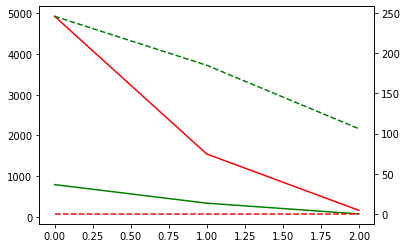

In [442]:
fig, axis = plt.subplots()

axis.plot(ucc_num_nonlocal, color='red')
axis.plot(eff_num_nonlocal, color='green')

axis_2 = axis.twinx()
axis_2.plot(ucc_num_params, color='red', ls='--')
axis_2.plot(eff_num_params, color='green', ls='--')

#axis.set_yscale('log')
#axis_2.set_yscale('log')

In [443]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel='ibm_quantum')

In [444]:
#program_id = service.upload_program(data="../../symmer/simulation/vqe_runtime.py", metadata=meta)
program_id = 'symmer-vqe-Ve6OdoVd8X'
prog = service.program(program_id)
print(f'Program name: {prog.name}')
print(f'Description:  {prog.description}')

Program name: symmer_vqe
Description:  VQE program using symmer


In [445]:
operator = ham_cs

QWC_decomposition = list(
    ObservableGraph(
        operator.symp_matrix, 
        operator.coeff_vec
    ).clique_cover(
        clique_relation='QWC', 
        colouring_strategy='largest_first'
    ).values()
)
assert(sum(QWC_decomposition)==operator), 'Decomposition into QWC groups failed'

In [446]:
ref_cs

array([0, 0, 0, 0])

In [667]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

#excitation_circuit = anz_cs.to_QuantumCircuit(bind_params=False)
excitation_circuit = EfficientSU2(n_qubits, su2_gates=['rx', 'ry'], entanglement='circular', reps=2, insert_barriers=True)

ansatz = QuantumCircuit(n_qubits)
for i in np.where(ref_cs)[0]:
    ansatz.x(n_qubits-1-i)
ansatz.barrier()
ansatz = ansatz.compose(excitation_circuit)

ansatz.decompose().draw()

░ ┌──────────┐┌──────────┐ ░ ┌───┐                ░  ┌──────────┐»
q_0: ─░─┤ Rx(θ[0]) ├┤ Ry(θ[4]) ├─░─┤ X ├──■─────────────░──┤ Rx(θ[8]) ├»
      ░ ├──────────┤├──────────┤ ░ └─┬─┘┌─┴─┐           ░  ├──────────┤»
q_1: ─░─┤ Rx(θ[1]) ├┤ Ry(θ[5]) ├─░───┼──┤ X ├──■────────░──┤ Rx(θ[9]) ├»
      ░ ├──────────┤├──────────┤ ░   │  └───┘┌─┴─┐      ░ ┌┴──────────┤»
q_2: ─░─┤ Rx(θ[2]) ├┤ Ry(θ[6]) ├─░───┼───────┤ X ├──■───░─┤ Rx(θ[10]) ├»
      ░ ├──────────┤├──────────┤ ░   │       └───┘┌─┴─┐ ░ ├───────────┤»
q_3: ─░─┤ Rx(θ[3]) ├┤ Ry(θ[7]) ├─░───■────────────┤ X ├─░─┤ Rx(θ[11]) ├»
      ░ └──────────┘└──────────┘ ░                └───┘ ░ └───────────┘»
«     ┌───────────┐ ░ ┌───┐                ░ ┌───────────┐┌───────────┐
«q_0: ┤ Ry(θ[12]) ├─░─┤ X ├──■─────────────░─┤ Rx(θ[16]) ├┤ Ry(θ[20]) ├
«     ├───────────┤ ░ └─┬─┘┌─┴─┐           ░ ├───────────┤├───────────┤
«q_1: ┤ Ry(θ[13]) ├─░───┼──┤ X ├──■────────░─┤ Rx(θ[17]) ├┤ Ry(θ[21]) ├
«     ├───────────┤ ░   │  └───┘┌─┴─┐      ░ ├───────────┤├───────────┤
«q_2: ┤ Ry(θ[14]) ├─░───┼───────┤ X ├──■───░─┤ Rx(θ[18]) ├┤ Ry(θ[22]) ├
«     ├───────────┤ ░   │       └───┘┌─┴─┐ ░ ├───────────┤├───────────┤
«q_3: ┤ Ry(θ[15]) ├─░───■────────────┤ X ├─░─┤ Rx(θ[19]) ├┤ Ry(θ[23]) ├
«     └───────────┘ ░                └───┘ ░ └───────────┘└───────────┘

In [668]:
backend_name = 'ibmq_qasm_simulator' #'ibm_nairobi'

options = {
    'backend_name': backend_name
}

inputs = {
    "ansatz": ansatz,
    "observable": ham_cs.to_PauliSumOp,
    "observable_groups": [op.to_PauliSumOp for op in QWC_decomposition],
    "init_params": None,
    "optimizer": 'SLSQP',
    "n_groups":5,
    "opt_setting": {"maxiter":10},#, "gtol": 1e-6},
    "n_shots": 2**12, # 18 < np.log2(0.0016**-2) < 19
    "n_realize":5
}

In [669]:
job = service.run(
    program_id=program_id, 
    options=options, 
    inputs=inputs,
    instance='ibm-q/open/main'
)

In [670]:
service.backend(backend_name).status()

In [671]:
print(f'Job ID: {job.job_id}')
print(f'Job status: {job.status()}')
#print(job.error_message())

Job ID: caqg7v9ihlmte2bncuf0
Job status: JobStatus.QUEUED


In [703]:
print(molecule.hf_energy, molecule.fci_energy)
job.interim_results()

-7.863115321486977 -7.882762230971985


['VQE complete',
 'Optimization step #12: energy = -7.865498445694541',
 'Optimization step #11: energy = -7.8627447258166425',
 'Optimization step #10: energy = -7.863923006583096',
 'Optimization step #9: energy = -7.8627681874090225',
 'Optimization step #8: energy = -7.863432249331166',
 'Optimization step #7: energy = -7.864444300517034',
 'Optimization step #6: energy = -7.862208248640083',
 'Optimization step #5: gradient norm = 0.04221601464002373',
 'Optimization step #5: energy = -7.864647823647802',
 'Optimization step #4: energy = -7.862623637315414',
 'Optimization step #3: energy = -7.862618748034732',
 'Optimization step #2: energy = -7.8635571188881785',
 'Optimization step #1: gradient norm = 0.03514058590108683',
 'Optimization step #1: energy = -7.864116968514535',
 'Optimization commencing']

In [704]:
vqe_result, interim_values = job.result()

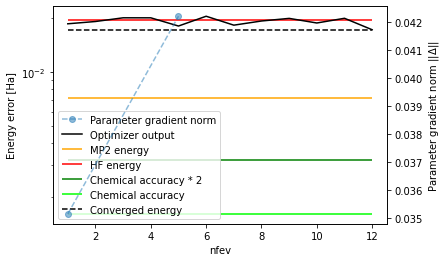

In [705]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots()
#while not job.status().value == 'job has successfully run':
X,Y = zip(*interim_values['values'])
X,Y = np.array(X), np.array(Y)
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 1, len(X), color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 1, len(X), color='red', label='HF energy')
axis.hlines(2*0.0016, 1, len(X), color='green', label='Chemical accuracy * 2')
axis.hlines(0.0016, 1, len(X), color='lime', label='Chemical accuracy')
axis.plot([], [], alpha=0.5, marker='o', ls='--', label='Parameter gradient norm')


axis.plot(X, abs(Y - molecule.fci_energy), color='black', label='Optimizer output')
axis.hlines(abs(vqe_result['fun'] - molecule.fci_energy), 1, len(X), color='black', label='Converged energy', ls='--')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
axis.set_yscale('log')

try:
    axis_param = axis.twinx()
    X_grad, Y_grads = zip(*interim_values['gradients'])
    Y_grad_norm = [np.sqrt(np.sum(np.square(grad))) for grad in Y_grads]
    axis_param.plot(X_grad, Y_grad_norm, alpha=0.5, marker='o', ls='--')
    axis_param.set_ylabel('Parameter gradient norm $||\Delta||$')
    #for param_grad in zip(*Y_grads):
    #    axis_param.plot(X_grad, param_grad, alpha=0.2)
except:
    pass

axis.legend()
plt.show()